# Predicting Airbnb Listing Prices in Seattle

By: Josh Keating, Ethan Katnic, Christian Hahn, Robin Yang

## Framing the Problem

The purpose of this project is to identify the aspects of Airbnb host listings that have a correlation to the frequency of achieving bookings. This information will allow Airbnb hosts to find and improve certain variables of their listing that can increase their number of bookings. The dataset used was the Seattle Airbnb Open Dataset found on Kaggle (https://www.kaggle.com/airbnb/seattle#calendar.csv). The two CSV files we are using from this set are calendar.csv and listings.csv. The calendar file displays the listing_id, the dates, whether it is available on that date, and the price of booking for that day. The listings file includes a wide variety of metadata scraped from the listing url.

On top of the given columns in the dataset, we used the Microsoft Azure Text Sentiment Analysis API to calculate the sentiment value (on a scale of 1 - 100) of the listing summary. Positive and negative sentiment can be identified and perhaps has a correlation to number of bookings. This was done using post requests on Postman and is known as scores.csv. 

## Import Libraries and Data

In [37]:
#import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from sklearn.neural_network import MLPRegressor

In [38]:
# read in clean data
airbnb_data_dummies = pd.read_csv('data/cleaned-listings-dummies.csv')
airbnb_data_basic = pd.read_csv('data/cleaned-listings-base.csv')


In [39]:
# Rename features with spaces in their names
airbnb_data_dummies.rename(index=str, columns={
    'neighbourhood_Beacon Hill': 'neighbourhood_Beacon_Hill',
    'neighbourhood_Capitol Hill': 'neighbourhood_Capitol_Hill',
    'neighbourhood_Central Area': 'neighbourhood_Central_Area',
    'neighbourhood_Lake City': 'neighbourhood_Lake_City',
    'neighbourhood_Other neighborhoods': 'neighbourhood_Other_neighborhoods',
    'neighbourhood_Queen Anne': 'neighbourhood_Queen_Anne',
    'neighbourhood_Rainier Valley': 'neighbourhood_Rainier_Valley',
    'neighbourhood_Seward Park': 'neighbourhood_Seward_Park',
    'neighbourhood_University District': 'neighbourhood_University_District',
    'neighbourhood_West Seattle': 'neighbourhood_West_Seattle',
    'property_type_Bed & Breakfast': 'property_type_Bed_Breakfast',
    'room_type_Entire home/apt': 'room_type_Entire_home_apt',
    'room_type_Private room': 'room_type_Private_room',
    'room_type_Shared room': 'room_type_Shared_room'
}, inplace=True)


In [40]:
# list(airbnb_data_dummies.columns.values)
# airbnb_data_dummies

### Use this regression to defend our feature selection

In [41]:
formula = 'price ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + score + host_is_superhost + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'

mod1 = smf.ols(formula=formula, data=airbnb_data_dummies).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     130.4
Date:                Mon, 03 Dec 2018   Prob (F-statistic):               0.00
Time:                        21:16:19   Log-Likelihood:                -20310.
No. Observations:                3705   AIC:                         4.070e+04
Df Residuals:                    3665   BIC:                         4.095e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -38.1985     15.877     -2.406      0.016     -69.327      -7.070
host_response_rate                   -0.1517      0.089     -1.697      0.090      -0.327       0.024
accommodates                          7.5074      1.171      6.412      0.000       5.212       9.803
guests_included                       3.3175      0.877      3.781      0.000       1.597       5.038
bathrooms                            27.5263      2.229     12.350      0.000      23.156      31.896
bedrooms                             32.3673      2.044     15.832      0.000      28.359      36.376
beds                                  1.0758      1.777      0.605      0.545      -2.408       4.560
number_of_reviews                    -0.1538      0.028     -5.505      0.000      -0.209      -0.099
review_scores_rating                  0.6969      0.265      2.628      0.009       0.177       1.217
review_scores_accuracy                2.7688      2.038      1.359      0.174      -1.226       6.764
review_scores_cleanliness             2.4932      1.785      1.397      0.163      -1.007       5.993
review_scores_checkin                -0.5157      2.521     -0.205      0.838      -5.458       4.426
review_scores_communication           0.3984      2.704      0.147      0.883      -4.904       5.701
review_scores_location                4.4394      1.965      2.260      0.024       0.588       8.291
review_scores_value                  -8.4751      2.048     -4.137      0.000     -12.491      -4.459
score                                -3.3947      5.496     -0.618      0.537     -14.170       7.381
host_is_superhost                     7.1544      2.561      2.794      0.005       2.134      12.175
neighbourhood_Ballard                -6.7646      4.258     -1.589      0.112     -15.112       1.583
neighbourhood_Cascade                23.9847      6.400      3.748      0.000      11.437      36.532
neighbourhood_Delridge              -24.4239      6.541     -3.734      0.000     -37.249     -11.599
neighbourhood_Downtown               33.2335      3.466      9.589      0.000      26.439      40.028
neighbourhood_Interbay                8.5666     17.567      0.488      0.626     -25.875      43.008
neighbourhood_Magnolia               17.3982      7.365      2.362      0.018       2.959      31.838
neighbourhood_Northgate             -30.3875      6.773     -4.487      0.000     -43.667     -17.108
property_type_Apartment             -17.6228      3.769     -4.675      0.000     -25.013     -10.232
property_type_Condominium           -12.4280      6.382     -1.947      0.052     -24.940       0.084
property_type_House                 -10.9984      3.748     -2.935      0.003     -18.346      -3.650
property_type_Loft     

In [42]:
# mod1_pred = mod1.predict(airbnb_data_dummies)
# mod1_pred

## Data Visualizations

A heatmap to view the correlations between variables right off the bat. The values are squared to see simple correlations rather than including negative correlations. We are most interested in those that are correlated with price, whcih include the number it accomodates nd number of bedrooms.

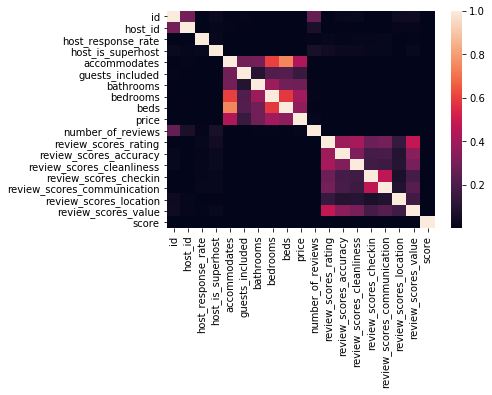

In [43]:
sns.heatmap(airbnb_data_basic.corr()**2)

Using the sentiment score calculated from the listing description, we visualized it against price. It was interesting to see that the few that had low sentiment had the lowest prices. Most tended to have high sentiment, which was expected as the descriptions are intended to sell the home.

Text(0.5,1,'Sentiment Score vs. Price')

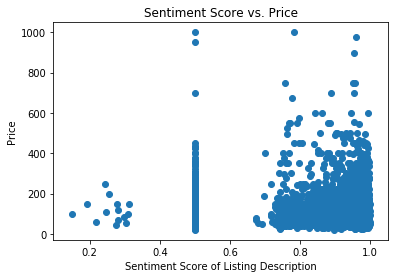

In [44]:
plt.scatter(airbnb_data_basic['score'], airbnb_data_basic['price'])
plt.xlabel('Sentiment Score of Listing Description')
plt.ylabel('Price')
plt.title('Sentiment Score vs. Price')

We also graphed the ten most expensive and least expensive neighborhoods. Housing prices are highly dependent on location and we believe that Airbnb prices will reflect the same thing. The neighborhood will likely have a high correlation with price.

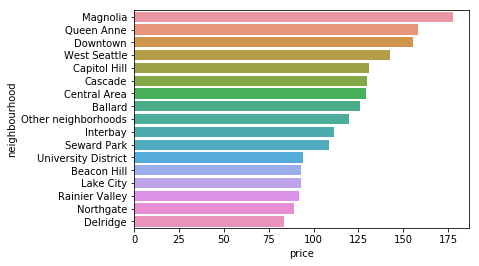

In [45]:
# neighborhood average price comparison 
prices_by_neighbourhood = airbnb_data_basic.groupby(['neighbourhood']).mean().price.sort_values(ascending=False)
neighbourhood_prices_df = pd.DataFrame(prices_by_neighbourhood)
neighbourhood_prices_df = neighbourhood_prices_df.reset_index()

sns.barplot(x="price", y="neighbourhood", data=neighbourhood_prices_df)

The graph below shows the listing price graphed against the number of reviews. The graph cascades down nicely and shows that higher priced listings have a significantly lower number of reviews. This is most likely due to them being out of affordable range for most.

Text(0.5,1,'Price of Listing vs. Number of Reviews')

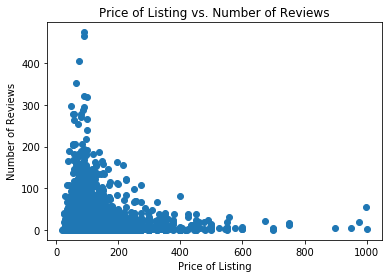

In [46]:
plt.scatter(airbnb_data_basic['price'], airbnb_data_basic['number_of_reviews'])
plt.xlabel('Price of Listing')
plt.ylabel('Number of Reviews')
plt.title('Price of Listing vs. Number of Reviews')

### Split data into Training and Test Sets

In [47]:
# split into train and test
train_features, test_features, train_outcome, test_outcome = train_test_split(
    airbnb_data_dummies.drop("price", axis=1),
    airbnb_data_dummies.price,
    test_size=0.20
)

### TODO: look at adding a variance thresh 

In [48]:
# KNN pipeline
knn_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(),
    KNeighborsRegressor(n_neighbors=4, weights="distance")
)

In [49]:
# Grid
knn_param_grid = {
              'polynomialfeatures__degree':range(1,2)
}

In [50]:
# RF
rf_pipeline = make_pipeline(
    SelectKBest(),
    MinMaxScaler(),
    PolynomialFeatures(1),
    RandomForestRegressor()
)

In [51]:
# RF Grid
rf_param_grid = { 
              'selectkbest__k':['all'],
              'randomforestregressor__n_estimators':range(1,100, 5),
              'randomforestregressor__max_depth':range(1,5)
}

In [52]:
# Neural Network Pipeline
nn_pipeline = make_pipeline(
    MinMaxScaler(),
    SelectKBest(),
    PolynomialFeatures(1),
    MLPRegressor()
)

In [53]:
nn_param_grid = {
              'selectkbest__k':['all'],
              'mlpregressor__learning_rate':["constant", "invscaling", "adaptive"],
              'mlpregressor__solver':["lbfgs", "sgd", "adam"],
              'mlpregressor__activation':["relu"]
}


In [54]:
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, scoring="neg_mean_absolute_error")
knn_grid.fit(train_features, train_outcome)
knn_grid.score(test_features, test_outcome)

-36.867350912005556

In [55]:
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring="neg_mean_absolute_error")
rf_grid.fit(train_features, train_outcome)
rf_grid.score(test_features, test_outcome)

-35.50728042153985

In [56]:
nn_grid = GridSearchCV(nn_pipeline, nn_param_grid, cv=3, scoring="neg_mean_absolute_error")
nn_grid.fit(train_features, train_outcome)
nn_grid.score(test_features, test_outcome)

-33.6289590458204

## NN plot

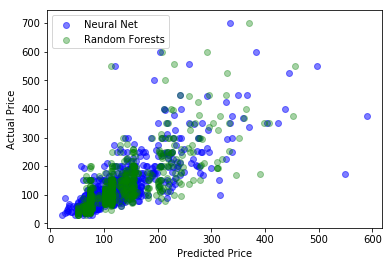

In [61]:
plt.scatter(nn_grid.predict(test_features),test_outcome,color='b', alpha = .5, label = 'Neural Net')
plt.scatter(rf_grid.predict(test_features),test_outcome,color='g', alpha = .35, label = 'Random Forests')
# plt.scatter(knn_grid.predict(test_features),test_outcome,color='r', alpha = .25, label = 'K-Nearest Neighbors')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.legend(loc='upper left')
plt.show()

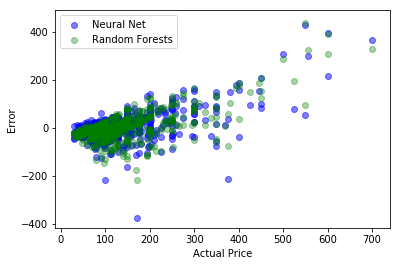

In [62]:
plt.scatter(test_outcome,test_outcome - nn_grid.predict(test_features),color='b', alpha = .5, label = 'Neural Net')
plt.scatter(test_outcome,test_outcome - rf_grid.predict(test_features),color='g', alpha = .35, label = 'Random Forests')
#plt.scatter(test_outcome,test_outcome - knn_grid.predict(test_features),color='g', alpha = .5, label = 'Random Forests')
plt.xlabel('Actual Price')
plt.ylabel('Error')
plt.legend(loc='upper left')
plt.show()

In [63]:
review_data = airbnb_data_dummies[airbnb_data_dummies.number_of_reviews > 3]

In [65]:
formula = 'review_scores_rating ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + price + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + score + host_is_superhost + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'

mod1 = smf.ols(formula=formula, data=review_data).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.719
Model:                              OLS   Adj. R-squared:                  0.715
Method:                   Least Squares   F-statistic:                     156.6
Date:                  Mon, 03 Dec 2018   Prob (F-statistic):               0.00
Time:                          21:18:24   Log-Likelihood:                -5878.0
No. Observations:                  2424   AIC:                         1.184e+04
Df Residuals:                      2384   BIC:                         1.207e+04
Df Model:                            39                                         
Covariance Type:              nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.4186      1.062     -0.394      0.694      -2.502       1.664
host_response_rate                    0.0064      0.006      1.123      0.261      -0.005       0.018
accommodates                         -0.0259      0.071     -0.367      0.714      -0.164       0.113
guests_included                      -0.0542      0.054     -1.003      0.316      -0.160       0.052
bathrooms                             0.1847      0.133      1.387      0.166      -0.077       0.446
bedrooms                              0.0574      0.128      0.450      0.653      -0.193       0.308
beds                                 -0.0528      0.105     -0.501      0.616      -0.260       0.154
number_of_reviews                    -0.0029      0.001     -2.014      0.044      -0.006   -7.51e-05
price                                 0.0036      0.001      3.477      0.001       0.002       0.006
review_scores_accuracy                1.6449      0.135     12.158      0.000       1.380       1.910
review_scores_cleanliness             2.0059      0.108     18.527      0.000       1.794       2.218
review_scores_checkin                 1.3627      0.169      8.077      0.000       1.032       1.694
review_scores_communication           1.7533      0.177      9.931      0.000       1.407       2.100
review_scores_location                0.9317      0.120      7.785      0.000       0.697       1.166
review_scores_value                   2.1174      0.125     16.935      0.000       1.872       2.363
score                                -0.1687      0.325     -0.519      0.604      -0.806       0.469
host_is_superhost                     0.6906      0.136      5.077      0.000       0.424       0.957
neighbourhood_Ballard                -0.4352      0.244     -1.786      0.074      -0.913       0.043
neighbourhood_Cascade                 0.1460      0.411      0.355      0.722      -0.660       0.952
neighbourhood_Delridge                0.5759      0.380      1.517      0.129      -0.168       1.320
neighbourhood_Downtown                0.0275      0.211      0.131      0.896      -0.386       0.441
neighbourhood_Interbay                1.2832      1.069      1.200      0.230      -0.813       3.380
neighbourhood_Magnolia               -0.1803      0.465     -0.388      0.698      -1.092       0.731
neighbourhood_Northgate              -0.6475      0.422     -1.536      0.125      -1.474       0.179
property_type_Apartment              -0.3143      0.243     -1.293      0.196      -0.791       0.162
property_type_Condominium            -0.1195      0.437     -0.274      0.784      -0.976       0.737
property_type_House                  -0.2185      0.243     -0.899      0.369      -0.695       0.258
p

In [66]:
review_data = review_data.drop('review_scores_accuracy',1)
review_data = review_data.drop('review_scores_cleanliness',1)
review_data = review_data.drop('review_scores_checkin',1)
review_data = review_data.drop('review_scores_communication',1)
review_data = review_data.drop('review_scores_location',1)
review_data = review_data.drop('review_scores_value',1)

In [67]:
formula = 'review_scores_rating ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + price + score + host_is_superhost + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'
mod1 = smf.ols(formula=formula, data=review_data).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.190
Model:                              OLS   Adj. R-squared:                  0.178
Method:                   Least Squares   F-statistic:                     16.94
Date:                  Mon, 03 Dec 2018   Prob (F-statistic):           5.77e-86
Time:                          21:19:29   Log-Likelihood:                -7162.7
No. Observations:                  2424   AIC:                         1.439e+04
Df Residuals:                      2390   BIC:                         1.459e+04
Df Model:                            33                                         
Covariance Type:              nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            55.9933      0.701     79.865      0.000      54.619      57.368
host_response_rate                    0.0639      0.009      6.730      0.000       0.045       0.083
accommodates                         -0.4196      0.119     -3.520      0.000      -0.653      -0.186
guests_included                      -0.0439      0.092     -0.479      0.632      -0.224       0.136
bathrooms                             0.4336      0.225      1.924      0.054      -0.008       0.876
bedrooms                              0.1790      0.216      0.829      0.407      -0.245       0.602
beds                                  0.0241      0.179      0.135      0.893      -0.326       0.374
number_of_reviews                    -0.0019      0.002     -0.795      0.427      -0.007       0.003
price                                 0.0074      0.002      4.206      0.000       0.004       0.011
score                                 0.4080      0.551      0.741      0.459      -0.672       1.488
host_is_superhost                     3.3366      0.220     15.139      0.000       2.904       3.769
neighbourhood_Ballard                 3.4956      0.390      8.962      0.000       2.731       4.261
neighbourhood_Cascade                 2.8058      0.689      4.075      0.000       1.456       4.156
neighbourhood_Delridge                4.7089      0.631      7.464      0.000       3.472       5.946
neighbourhood_Downtown                3.1369      0.332      9.462      0.000       2.487       3.787
neighbourhood_Interbay                4.6112      1.810      2.548      0.011       1.062       8.161
neighbourhood_Magnolia                2.7767      0.779      3.563      0.000       1.248       4.305
neighbourhood_Northgate               3.9788      0.704      5.652      0.000       2.598       5.359
property_type_Apartment               8.6608      0.311     27.832      0.000       8.051       9.271
property_type_Condominium            10.0250      0.682     14.705      0.000       8.688      11.362
property_type_House                   8.8591      0.313     28.312      0.000       8.246       9.473
property_type_Loft                    8.5975      0.864      9.951      0.000       6.903      10.292
property_type_Townhouse              10.5966      0.602     17.595      0.000       9.416      11.778
neighbourhood_Beacon_Hill             2.8665      0.528      5.429      0.000       1.831       3.902
neighbourhood_Capitol_Hill            2.5752      0.303      8.509      0.000       1.982       3.169
neighbourhood_Central_Area            4.0713      0.333     12.211      0.000       3.417       4.725
neighbourhood_Lake_City               2.9169      0.701      4.163      0.000       1.543       4.291
n